In [1]:
import torch
import torch.nn as nn

In [2]:
# 卷积对输入图X通过卷积核K进行卷积操作的函数
def My_conv2d(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
print("original X: ")
print(X)
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
print("convolution kernel K: ")
print(K)
print("\nafter convolution: ")
print(My_conv2d(X, K))

original X: 
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])
convolution kernel K: 
tensor([[0., 1.],
        [2., 3.]])

after convolution: 
tensor([[19., 25.],
        [37., 43.]])


In [4]:
# 利用简单卷积核对自己写的卷积函数的正确性进行验证
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [5]:
# 类似检测竖直边缘的卷积核
K = torch.tensor([[1.0, -1.0]])
K

tensor([[ 1., -1.]])

In [6]:
Y = My_conv2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [7]:
# 将手写的卷积操作放入自定义的卷积层
class My_Con2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, X):
        return My_conv2d(X, self.weight) + self.bias

In [8]:
# 手写一个梯度下降来对卷积核参数进行学习
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
my_conv2d = My_Con2D(kernel_size=(1, 2))

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = torch.rand(6,8)
Y = torch.rand(6,7)

learning_rate = 0.002
epoch_num = 10
for i in range(epoch_num):
    Y_hat = my_conv2d(X)
    l = ((Y_hat - Y)**2).sum()  # 计算MSE作为loss
    my_conv2d.zero_grad()  # 计算梯度
    l.backward()  # 反向传播计算梯度
    # 参数更新，具体学习过程
    my_conv2d.weight.data[:] -= learning_rate * my_conv2d.weight.grad
    print("loss of epoch"+ str(i)+": " + f'{l:.3f}')


loss of epoch0: 7.202
loss of epoch1: 6.773
loss of epoch2: 6.413
loss of epoch3: 6.109
loss of epoch4: 5.854
loss of epoch5: 5.638
loss of epoch6: 5.457
loss of epoch7: 5.305
loss of epoch8: 5.177
loss of epoch9: 5.069


# 下面是关于多输入输出通道的卷积的实验

In [10]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    # 先遍历 “X” 和 “K” 的第0号维度（通道维度），再把它们加在一起
    return sum(My_conv2d(x, k) for x, k in zip(X, K))

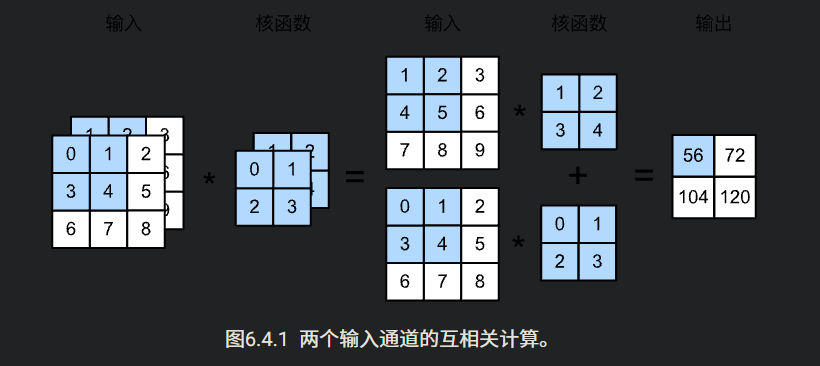

In [11]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])x`
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [12]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0号维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)  # 结果在第0维度(输出通道维度)上进行堆叠

In [13]:
K = torch.stack((K, K + 1, K + 2), 0)  # 在第0维度上进行堆叠作为输出通道，相当于对每个输出通道创建一组卷积核(通过K+1与K+2操作)
K.shape  # [output_channel, input_channel, kw, kh]

torch.Size([3, 2, 2, 2])

In [14]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

# 下面是关于1×1卷积核的实验

In [15]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))  # 将h,w的矩阵拉成一个h*w的向量，再通过乘法实现1×1的卷积操作
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)  # 这边K@W是因为前面把K给reshape成了c_o,c_i
    return Y.reshape((c_o, h, w))  # 最后reshape回去

In [16]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6  # 浮点精度误差，＜ 1e-6认为基本相等